# First Agent

In [187]:
from typing import Annotated, Optional

from typing_extensions import TypedDict

from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema import SystemMessage, HumanMessage
from IPython.display import Image, display

import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

In [188]:
# class State(TypedDict):
#     messages: Annotated[list, add_messages]

In [189]:
# load_dotenv(override=True)

# os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# llm = init_chat_model("openai:gpt-4o-mini")

In [190]:
# def chatbot(state: State) -> State:
#     return {"messages": [llm.invoke(state["messages"])]}

# graph_builder = StateGraph(State)
# graph_builder.add_node("chatbot", chatbot)
# graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)

# graph = graph_builder.compile()


In [191]:
# def chat(user_input):
#     initial_state = {"messages": [{'role': 'user', 'content': user_input}]}
#     result = graph.invoke(initial_state)
#     return result['messages'][-1].content

# chat("Hello, how are you?")

# State and Structured Output

In [192]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    feedback_on_work: Optional[str]
    rubric: str
    candidates: Optional[list[str]]
    score: Optional[int]
    reason: Optional[str]
    accepted: Optional[bool]

# class RubricState(TypedDict):
#     rubric: dict

# class CandidateState(TypedDict):
#     candidates: list[str]
#     answer: str

In [193]:
class CompareOutput(BaseModel):
    score: int
    reason: str

class JudgeOutput(BaseModel):
    accepted: bool


# Initialize LLM

In [194]:
load_dotenv(override=True)

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [195]:
compare_llm = ChatOpenAI(model='gpt-4o-mini')
compare_llm_structured = compare_llm.with_structured_output(CompareOutput)

judge_llm = ChatOpenAI(model='gpt-4o-mini')
judge_llm_structured = judge_llm.with_structured_output(JudgeOutput)

### Define the agent function

In [196]:
def compare_node(state: AgentState) -> AgentState:
    system_message =  f"""You are a helpful assistant that compares candidate answers STRICTLY based on the given rubric.
    Be very strict and follow ONLY what the rubric says.
    Do not invent or assume any new rules.
    Give a score exactly as defined by the rubric, and explain briefly why that score fits
    keep your reason short and directly tied to the rubric, do not add anything or hallucinate.

    Here is the rubric:

    {state.get('rubric', '')}
    """

    compare_response = compare_llm_structured.invoke([SystemMessage(content=system_message)] + state['messages']) 
    
    return { **state, 'score': compare_response.score, 'reason': compare_response.reason }


In [197]:
def judge_node(state: AgentState) -> AgentState:
    system_message = f"""You are a helpful assistant that judges if the reason and score provided by the previous agent aligns with the rubric or not. I want you
    to be very strict about the judge.
    
    Here is the rubric
    {state.get('rubric', '')}
    """

    messages = [HumanMessage(content=f"Score: {state['score']} \n Reason: {state['reason']}")]

    judge_response = judge_llm_structured.invoke([SystemMessage(content=system_message)] + messages)

    return { **state, 'accepted': judge_response.accepted}

    

# Define the Graph

In [198]:
agent_graph = StateGraph(AgentState)

agent_graph.add_node('compare', compare_node)
agent_graph.add_node('judge', judge_node)

agent_graph.add_edge(START, 'compare')
agent_graph.add_edge('compare', 'judge')
agent_graph.add_edge('judge', END)

agent_graph = agent_graph.compile()


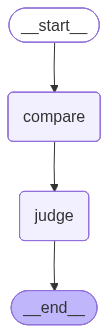

In [199]:
display(Image(agent_graph.get_graph().draw_mermaid_png()))

In [200]:
def chat(state: AgentState):

    result = agent_graph.invoke(state)

    return {'accepted': result['accepted'], 'score': result['score'], 'reason': result['reason']}

initial_state: AgentState = {
    'messages': [HumanMessage(content="Telkomsel is a company that sells package data and streaming services")],
    'feedback_on_work': None,
    'rubric': """This question is scored out of 3 points.

1 point: The answer mentions at most two specific products or services that the company provides.
2 points: The answer mentions exactly three products or services but gives little or no explanation.
3 points: The answer mentions three or more products or services and clearly explains what each one is or how it relates to the company.
""",
    'candidates': None,
    'score': None,
    'reason': None

} 

response = chat(initial_state)
print(response)


{'accepted': True, 'score': 1, 'reason': 'The answer mentions two specific products (package data and streaming services), which fits the criterion for 1 point.'}
